# Quantization Aware Training with NNCF, using TensorFlow framework

The goal of this notebook to demonstrate how to use the Neural Network Compression Framework [NNCF](https://github.com/openvinotoolkit/nncf) 8-bit quantization to optimize a TensorFlow model for inference with OpenVINO Toolkit. The optimization process contains the following steps:
* Fine-tuning of FP32 model
* Transform the original FP32 model to INT8
* Use fine-tuning to restore the accuracy
* Export optimized and original models to Frozen Graph and then to OpenVINO
* Measure and compare the performance of models

For more advanced usage, please refer to these [examples](https://github.com/openvinotoolkit/nncf/tree/develop/examples).

We selected the ResNet-18 model with Imagenette dataset. Imagenette is a subset of 10 easily classified classes from the Imagenet dataset. Using the smaller model and dataset will speed up training and download time. To see other Keras models, visit [tf.keras.applications](https://www.tensorflow.org/api_docs/python/tf/keras/applications#functions) module.

## Imports and Settings

Import NNCF and all auxiliary packages from your Python* code.
Set a name for the model, input image size, used batch size, and the learning rate. Also define paths where Frozen Graph and OpenVINO IR versions of the models will be stored.

In [1]:
from pathlib import Path
from urllib.request import urlretrieve

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
from tensorflow.python.keras import backend
from tensorflow.python.keras import layers
from tensorflow.python.keras import models

from nncf import NNCFConfig
from nncf.tensorflow.helpers.model_creation import create_compressed_model
from nncf.tensorflow.initialization import register_default_init_args

MODEL_DIR = Path("model")
OUTPUT_DIR = Path("output")
MODEL_DIR.mkdir(exist_ok=True)
OUTPUT_DIR.mkdir(exist_ok=True)

BASE_MODEL_NAME = "ResNet-18"

fp32_h5_path = Path(MODEL_DIR / (BASE_MODEL_NAME + "_fp32")).with_suffix(".h5")
fp32_pb_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_fp32")).with_suffix(".pb")
fp32_pb_name = Path(BASE_MODEL_NAME + "_fp32").with_suffix(".pb")
fp32_ir_path = fp32_pb_path.with_suffix(".xml")
int8_pb_path = Path(OUTPUT_DIR / (BASE_MODEL_NAME + "_int8")).with_suffix(".pb")
int8_pb_name = Path(BASE_MODEL_NAME + "_int8").with_suffix(".pb")
int8_ir_path = int8_pb_path.with_suffix(".xml")

BATCH_SIZE = 128
IMG_SIZE = (224, 224)  # Default Imagenet image size
NUM_CLASSES = 10  # For Imagenette dataset

LR = 1e-5

MEAN_RGB = (0.485 * 255, 0.456 * 255, 0.406 * 255)
STDDEV_RGB = (0.229 * 255, 0.224 * 255, 0.225 * 255)

fp32_pth_url = "https://storage.openvinotoolkit.org/repositories/nncf/openvino_notebook_ckpts/305_resnet18_imagenette_fp32.h5"
urlretrieve(fp32_pth_url, fp32_h5_path)

## Dataset preprocessing

Download and prepare Imagenette 160px dataset.
- Number of classes: 10
- Download size: 94.18 MiB
| Split        | Examples |
|--------------|----------|
| 'train'      | 12,894   |
| 'validation' | 500      |

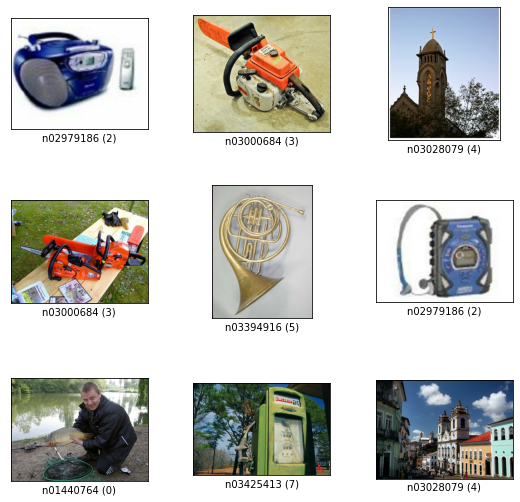

In [2]:
datasets, datasets_info = tfds.load('imagenette/320px', shuffle_files=True, as_supervised=True, with_info=True)
train_dataset, validation_dataset = datasets['train'], datasets['validation']
fig = tfds.show_examples(train_dataset, datasets_info)

In [3]:
def preprocessing(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = image - MEAN_RGB
    image = image / STDDEV_RGB
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label


train_dataset = (train_dataset.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)  # .shuffle(datasets_info.splits['train'].num_examples)
                              .batch(BATCH_SIZE)
                              .prefetch(tf.data.experimental.AUTOTUNE)
                )

validation_dataset = (validation_dataset.map(preprocessing, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                                        .batch(BATCH_SIZE)
                                        .prefetch(tf.data.experimental.AUTOTUNE)
                     )

## Define a floating-point model

In [4]:
def handle_block_names(stage, block):
    name_base = 'stage{}_unit{}_'.format(stage + 1, block + 1)
    conv_name = name_base + 'conv'
    bn_name = name_base + 'bn'
    relu_name = name_base + 'relu'
    sc_name = name_base + 'sc'
    return conv_name, bn_name, relu_name, sc_name


def get_conv_params(**params):
    default_conv_params = {
        'kernel_initializer': 'he_uniform',
        'use_bias': False,
        'padding': 'valid',
    }
    default_conv_params.update(params)
    return default_conv_params


def get_bn_params(**params):
    axis = 3 if backend.image_data_format() == 'channels_last' else 1
    default_bn_params = {
        'axis': axis,
        'momentum': 0.99,
        'epsilon': 2e-5,
        'center': True,
        'scale': True,
    }
    default_bn_params.update(params)
    return default_bn_params


def residual_conv_block(filters, stage, block, strides=(1, 1), attention=None, cut='pre'):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of
            middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
        cut: one of 'pre', 'post'. used to decide where skip connection is taken
    # Returns
        Output tensor for the block.
    """

    def layer(input_tensor):

        # get params and names of layers
        conv_params = get_conv_params()
        bn_params = get_bn_params()
        conv_name, bn_name, relu_name, sc_name = handle_block_names(stage, block)

        x = layers.BatchNormalization(name=bn_name + '1', **bn_params)(input_tensor)
        x = layers.Activation('relu', name=relu_name + '1')(x)

        # defining shortcut connection
        if cut == 'pre':
            shortcut = input_tensor
        elif cut == 'post':
            shortcut = layers.Conv2D(filters, (1, 1), name=sc_name, strides=strides, **conv_params)(x)
        else:
            raise ValueError('Cut type not in ["pre", "post"]')

        # continue with convolution layers
        x = layers.ZeroPadding2D(padding=(1, 1))(x)
        x = layers.Conv2D(filters, (3, 3), strides=strides, name=conv_name + '1', **conv_params)(x)

        x = layers.BatchNormalization(name=bn_name + '2', **bn_params)(x)
        x = layers.Activation('relu', name=relu_name + '2')(x)
        x = layers.ZeroPadding2D(padding=(1, 1))(x)
        x = layers.Conv2D(filters, (3, 3), name=conv_name + '2', **conv_params)(x)

        # use attention block if defined
        if attention is not None:
            x = attention(x)

        # add residual connection
        x = layers.Add()([x, shortcut])
        return x

    return layer


def ResNet(model_name, repetitions, residual_block, attention, input_shape=None, include_top=True,
           classes=1000, weights='imagenet', **kwargs):
    """Instantiates the ResNet architecture.
    Optionally loads weights pre-trained on ImageNet.
    Args:
        include_top: whether to include the fully-connected
            layer at the top of the network.
        weights: one of `None` (random initialization),
              'imagenet' (pre-training on ImageNet),
              or the path to the weights file to be loaded.
        input_shape: optional shape tuple, only to be specified
            if `include_top` is False (otherwise the input shape
            has to be `(224, 224, 3)` (with `channels_last` data format)
            or `(3, 224, 224)` (with `channels_first` data format).
            It should have exactly 3 inputs channels.
        classes: optional number of classes to classify images
            into, only to be specified if `include_top` is True, and
            if no `weights` argument is specified.
    Returns:
        A Keras model instance.
    Raises:
        ValueError: in case of invalid argument for `weights`,
            or invalid input shape.
    """

    img_input = layers.Input(shape=input_shape, name='data')

    # choose residual block type
    ResidualBlock = residual_block
    if attention:
        Attention = attention(**kwargs)
    else:
        Attention = None

    # get parameters for model layers
    no_scale_bn_params = get_bn_params(scale=False)
    bn_params = get_bn_params()
    conv_params = get_conv_params()
    init_filters = 64

    # resnet bottom
    x = layers.BatchNormalization(name='bn_data', **no_scale_bn_params)(img_input)
    x = layers.ZeroPadding2D(padding=(3, 3))(x)
    x = layers.Conv2D(init_filters, (7, 7), strides=(2, 2), name='conv0', **conv_params)(x)
    x = layers.BatchNormalization(name='bn0', **bn_params)(x)
    x = layers.Activation('relu', name='relu0')(x)
    x = layers.ZeroPadding2D(padding=(1, 1))(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='valid', name='pooling0')(x)

    # resnet body
    for stage, rep in enumerate(repetitions):
        for block in range(rep):

            filters = init_filters * (2 ** stage)

            # first block of first stage without strides because we have maxpooling before
            if block == 0 and stage == 0:
                x = ResidualBlock(filters, stage, block, strides=(1, 1),
                                  cut='post', attention=Attention)(x)

            elif block == 0:
                x = ResidualBlock(filters, stage, block, strides=(2, 2),
                                  cut='post', attention=Attention)(x)

            else:
                x = ResidualBlock(filters, stage, block, strides=(1, 1),
                                  cut='pre', attention=Attention)(x)

    x = layers.BatchNormalization(name='bn1', **bn_params)(x)
    x = layers.Activation('relu', name='relu1')(x)

    # resnet top
    if include_top:
        x = layers.GlobalAveragePooling2D(name='pool1')(x)
        x = layers.Dense(classes, name='fc1')(x)
        x = layers.Activation('softmax', name='softmax')(x)

    # Create model.
    model = models.Model(img_input, x)

    if weights:
        model.load_weights(weights)

    return model


def ResNet18(input_shape=None, weights=None, classes=1000, include_top=True, **kwargs):
    return ResNet(
        model_name='resnet18',
        repetitions=(2, 2, 2, 2),
        residual_block=residual_conv_block,
        attention=None,
        input_shape=input_shape,
        include_top=include_top,
        classes=classes,
        weights=weights,
        **kwargs
    )

In [5]:
IMG_SHAPE = IMG_SIZE + (3,)
# weights_path = "/home/negvet/nncf/examples/tensorflow/classification/runs/ResNet18_imagenette/resnet18_imagenette_fp32.h5"

model = ResNet18(input_shape=IMG_SHAPE, classes=10, weights=fp32_h5_path)

## Pre-train floating-point model

Using NNCF for model compression assumes that the user has a pre-trained model and a training pipeline.

Here we demonstrate one possible training pipeline: ResNet-18 model pre-trained on 1000 classes from ImageNet and fine-tuned with 10 classes from Imagenette.

Subsequently, the training and validation functions will be reused for quantization-aware training.

> **NOTE** The model is not tuned till the final accuracy. For the sake of simplicity of the tutorial, we tune for 4 epochs only and take the last model state for quantization.

In [ ]:
# # Compile the floating-point model
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# # Train the floating-point model
# model.fit(train_dataset,
#           epochs=1,  # 4
#           validation_data=validation_dataset)

# # Validate the floating-point model
# test_loss, test_acc = model.evaluate(validation_dataset)
# print(f"\nAccuracy of FP32 model: {test_acc:.3f}")

In [6]:
# Compile the floating-point model
model.compile(metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc@1')])

# Validate the floating-point model
test_loss, test_acc = model.evaluate(validation_dataset)
print(f"\nAccuracy of FP32 model: {test_acc:.3f}")

4/4 [==============================] - 3s 187ms/step - loss: 0.0000e+00 - acc@1: 0.9674

Accuracy of FP32 model: 0.972


Save the floating-point model to the frozen graph, which will be later used for conversion to OpenVINO IR and further performance measurement.

In [7]:
def export_model_to_frozen_graph(model, output_dir, model_name):
    # Convert Keras model to the frozen graph.
    input_signature = []
    for item in model.inputs:
        input_signature.append(tf.TensorSpec(item.shape, item.dtype, item.name))
    concrete_function = tf.function(model).get_concrete_function(input_signature)
    frozen_func = convert_variables_to_constants_v2(concrete_function, lower_control_flow=False)
    frozen_graph = frozen_func.graph.as_graph_def(add_shapes=True)
    
    tf.io.write_graph(frozen_graph, output_dir, model_name, as_text=False)


export_model_to_frozen_graph(model, OUTPUT_DIR, fp32_pb_name)

## Create and initialize quantization

NNCF enables compression-aware training by integrating into regular training pipelines. The framework is designed so that modifications to your original training code are minor. Quantization is the simplest scenario and requires only 3 modifications.

1. Configure NNCF parameters to specify compression

In [8]:
nncf_config_dict = {
    "input_info": {"sample_size": [1, 3] + list(IMG_SIZE)},
    "log_dir": str(OUTPUT_DIR),  # log directory for NNCF-specific logging outputs
    "compression": {
        "algorithm": "quantization",  # specify the algorithm here
        "initializer": {
            "batchnorm_adaptation": {
                "num_bn_adaptation_samples": 2048  # change the default number of samples for BatchNormalization adaptation
            }
        }
    },
}
nncf_config = NNCFConfig.from_dict(nncf_config_dict)

2. Provide data loader to initialize the values of quantization ranges and determine which activation should be signed or unsigned from the collected statistics using a given number of samples.

In [9]:
nncf_config = register_default_init_args(nncf_config=nncf_config,
                                         data_loader=train_dataset,
                                         batch_size=BATCH_SIZE)

3. Create a wrapped model ready for compression fine-tuning from a pre-trained FP32 model and configuration object.

In [10]:
compression_ctrl, model = create_compressed_model(model, nncf_config, None)

INFO:nncf:Creating compression algorithm: quantization
INFO:nncf:Collecting tensor statistics/data ████████          | 1 / 2
INFO:nncf:Collecting tensor statistics/data ████████████████  | 2 / 2
INFO:nncf:BatchNorm statistics adaptation █                 | 1 / 16
INFO:nncf:BatchNorm statistics adaptation ██                | 2 / 16
INFO:nncf:BatchNorm statistics adaptation ███               | 3 / 16
INFO:nncf:BatchNorm statistics adaptation ████              | 4 / 16
INFO:nncf:BatchNorm statistics adaptation █████             | 5 / 16
INFO:nncf:BatchNorm statistics adaptation ██████            | 6 / 16
INFO:nncf:BatchNorm statistics adaptation ███████           | 7 / 16
INFO:nncf:BatchNorm statistics adaptation ████████          | 8 / 16
INFO:nncf:BatchNorm statistics adaptation █████████         | 9 / 16
INFO:nncf:BatchNorm statistics adaptation ██████████        | 10 / 16
INFO:nncf:BatchNorm statistics adaptation ███████████       | 11 / 16
INFO:nncf:BatchNorm statistics adaptation ██

Evaluate the new model on the validation set after initialization of quantization. The accuracy should be not far from the accuracy of the floating-point FP32 model for a simple case like the one we are demonstrating now.

In [11]:
# # Compile the int8 model
# model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR),
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

# # Validate the int8 model
# test_loss, test_acc = model.evaluate(validation_dataset)
# print(f"\nAccuracy of INT8 model after initialization: {test_acc:.3f}")

In [12]:
# Compile the int8 model
model.compile(optimizer=tf.keras.optimizers.Adam(lr=LR),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              metrics=[tf.keras.metrics.CategoricalAccuracy(name='acc@1')])

# Validate the int8 model
test_loss, test_acc = model.evaluate(validation_dataset)
print(f"\nAccuracy of INT8 model after initialization: {test_acc:.3f}")

4/4 [==============================] - 1s 88ms/step - loss: 0.6575 - acc@1: 0.9646

Accuracy of INT8 model after initialization: 0.970


## Fine-tune the compressed model

At this step, a regular fine-tuning process is applied to restore accuracy drop. Normally, several epochs of tuning are required with a small learning rate, the same that is usually used at the end of the training of the original model. No other changes in the training pipeline are required. Here is a simple example.

In [13]:
# Train the int8 model
model.fit(train_dataset,
          epochs=1)  # 2

# Validate the int8 model
test_loss, test_acc = model.evaluate(validation_dataset)
print(f"\nAccuracy of INT8 model after fine-tuning: {test_acc:.3f}")

4/4 [==============================] - 0s 85ms/step - loss: 0.6248 - acc@1: 0.9740

Accuracy of INT8 model after fine-tuning: 0.974


Save the INT8 model to the frozen graph, which will be later used for conversion to OpenVINO IR and further performance measurement.

In [14]:
export_model_to_frozen_graph(model, OUTPUT_DIR, int8_pb_name)

## Export Frozen Graph models to OpenVINO™ Intermediate Representation (IR)

Call the OpenVINO Model Optimizer tool to convert the Frozen Graph model to OpenVINO IR. The models are saved to the current directory.

See the [Model Optimizer Developer Guide](https://docs.openvinotoolkit.org/latest/openvino_docs_MO_DG_Deep_Learning_Model_Optimizer_DevGuide.html) for more information about Model Optimizer.

Executing this command may take a while. There may be some errors or warnings in the output. Model Optimization successfully export to IR if the last lines of the output include: `[ SUCCESS ] Generated IR version 10 model`

In [ ]:
if not fp32_ir_path.exists():
    !mo  --framework=tf --reverse_input_channels --input_shape=[1,224,224,3] --input=Placeholder --input_model=$fp32_pb_path --output_dir=$OUTPUT_DIR

Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	/home/negvet/openvino_notebooks/notebooks/305-tensorflow-quantization-aware-training/output/ResNet-18_fp32.pb
	- Path for generated IR: 	/home/negvet/openvino_notebooks/notebooks/305-tensorflow-quantization-aware-training/output
	- IR output name: 	ResNet-18_fp32
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Placeholder
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,224,224,3]
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- Enable grouped convolutions fusing: 	True
	- Move mean values to preprocess section: 	None
	- Reverse input channels: 	True
TensorFlow specific parameters:
	- Input model in text protobuf format: 	False
	- Path to model dump for TensorBoard: 	None
	- List of shared libraries with TensorFlow custom layers implementation

In [ ]:
if not int8_ir_path.exists():
    !mo  --framework=tf --reverse_input_channels --input_shape=[1,224,224,3] --input=Placeholder --input_model=$int8_pb_path --output_dir=$OUTPUT_DIR

## Benchmark model performance by computing inference time

Finally, we will measure the inference performance of the FP32 and INT8 models. To do this, we use [Benchmark Tool](https://docs.openvinotoolkit.org/latest/openvino_inference_engine_tools_benchmark_tool_README.html) - OpenVINO's inference performance measurement tool. By default, Benchmark Tool runs inference for 60 seconds in asynchronous mode on CPU. It returns inference speed as latency (milliseconds per image) and throughput (frames per second) values.

> **NOTE**: In this notebook we run benchmark_app for 15 seconds to give a quick indication of performance. For more accurate performance, we recommended running benchmark_app in a terminal/command prompt after closing other applications. Run benchmark_app -m model.xml -d CPU to benchmark async inference on CPU for one minute. Change CPU to GPU to benchmark on GPU. Run benchmark_app --help to see an overview of all command line options.

In [29]:
def parse_benchmark_output(benchmark_output):
    parsed_output = [line for line in benchmark_output if not (line.startswith(r"[") or line.startswith("  ") or line == "")]
    print(*parsed_output, sep='\n')


print('Benchmark FP32 model (IR)')
benchmark_output = ! benchmark_app -m $fp32_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

print('\nBenchmark INT8 model (IR)')
benchmark_output = ! benchmark_app -m $int8_ir_path -d CPU -api async -t 15
parse_benchmark_output(benchmark_output)

Benchmark FP32 model (IR)
Count:      7164 iterations
Duration:   15009.98 ms
Latency:    12.53 ms
Throughput: 477.28 FPS

Benchmark INT8 model (IR)
Count:      24354 iterations
Duration:   15005.31 ms
Latency:    3.64 ms
Throughput: 1623.03 FPS


Show CPU Information for reference

In [30]:
try:
    import cpuinfo

    print(cpuinfo.get_cpu_info()["brand_raw"])
except Exception:
    # OpenVINO installs cpuinfo, but if a different version is installed
    # the command above may not work
    print(platform.processor())

Intel(R) Core(TM) i9-10920X CPU @ 3.50GHz


In [ ]:
mean1 = tf.keras.metrics.Mean()
mean2 = tf.keras.metrics.Mean()
mean3 = tf.keras.metrics.Mean()
for (batch, labels) in train_dataset:
    mean1.update_state(batch[:,:,0])
    mean2.update_state(batch[:,:,1])
    mean3.update_state(batch[:,:,2])

print(mean1.result().numpy())
print(mean2.result().numpy())
print(mean3.result().numpy())

train_dataset.reduce(0, lambda x, _: tf.math.reduce_mean(x)).numpy()